In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import tensorflow as tf
import sys
sys.path.append('..')

/home/data_sapiens/Anaconda/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [50]:
from importlib import reload
import stonks
reload(stonks)
import stonks

In [2]:
tf.__version__

'2.0.0-alpha0'

In [3]:
from stonks.DataCatcher import DB
from stonks.auxiliary.data_preprocessing import make_x_y

In [4]:
db = DB()

In [5]:
week_data = db.fetch_last(7 * 24 * 3600, ['btcusdt'])

In [227]:
wow_data = db.fetch_last(3600 * 24 * 30, ['btcusdt'])

In [7]:
import datetime
target = (week_data['depth_bid_price_1'] + week_data['depth_ask_price_1']) / 2.
target.index = week_data['time'].apply(datetime.datetime.fromtimestamp)

In [8]:
data = week_data.copy()

In [9]:
import warnings
warnings.filterwarnings('ignore')

In [54]:
from stonks.auxiliary.data_preprocessing import basic_clean, get_kline_info, construct_order_names, get_state_fast
from stonks.auxiliary.data_preprocessing import count_some, rolling

data = basic_clean(data)
kli = get_kline_info(data)
orders = data[construct_order_names(5)]
some = count_some(orders, 5)
some.drop(construct_order_names(5), axis=1, inplace=True)
y = get_state_fast(some['mid_price'], 0.001)
some = pd.concat([some, rolling(some['mid_price'])], axis=1)
some.drop('mid_price', axis=1, inplace=True)
klid = pd.DataFrame(data['kline_id']).join(kli, on='kline_id').drop('kline_id', axis=1)
x = pd.concat([klid, some], axis=1)
x.fillna(0., inplace=True)

In [64]:
x = x.replace({-np.inf: np.NaN})
x.fillna(0., inplace=True)

In [45]:
x1.isna().sum()[x1.isna().sum() != 0]

volatility_bbp          1467
volatility_kcp            52
trend_vortex_ind_pos     313
trend_vortex_ind_neg     736
trend_cci                530
dtype: int64

In [65]:
scaler = StandardScaler()
scaler.fit(x)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [49]:
X, y, scaler = make_x_y(data, mod=0.001)

ValueError: Input contains infinity or a value too large for dtype('float64').

In [63]:
(x == -np.inf).sum().sum()

3517

In [10]:
y_cat = tf.keras.utils.to_categorical(y)

In [11]:
model = tf.keras.Sequential(name='btcusdt model')
model.add(tf.keras.layers.Dense(64, input_shape=(109,), activation='relu'))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(2, activation='softmax'))

model.compile('adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "btcusdt model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                7040      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 34        
Total params: 9,682
Trainable params: 9,682
Non-trainable params: 0
___________________________________________________

In [41]:
from sklearn.metrics import roc_auc_score, f1_score


In [12]:
from sklearn.model_selection import train_test_split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, shuffle=False)

In [14]:
from sklearn.utils import shuffle

In [15]:
X_train, y_train = shuffle(X_train, y_train)

In [16]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), shuffle=False, epochs=3, batch_size=512)

Train on 2325 samples, validate on 775 samples
Epoch 1/3
2325/2325 [==============================] - 0s 136us/sample - loss: 0.8211 - accuracy: 0.6090 - val_loss: 0.6439 - val_accuracy: 0.6439
Epoch 2/3
2325/2325 [==============================] - 0s 9us/sample - loss: 0.6580 - accuracy: 0.6378 - val_loss: 0.6012 - val_accuracy: 0.6606
Epoch 3/3
2325/2325 [==============================] - 0s 12us/sample - loss: 0.6281 - accuracy: 0.6649 - val_loss: 0.5922 - val_accuracy: 0.6735


In [23]:
from stonks.auxiliary.model_selection import plot_predictions

In [108]:
proba = model.predict(X_test)
probas = pd.DataFrame(proba, columns=['goes_down', 'goes_up'], index=X_test.index)
y_pred = (probas['goes_up'] > probas['goes_down']).apply(int)
y_pred.value_counts()

1    78947
0    46554
dtype: int64

In [109]:
y_not = y_test[:,1]
pd.Series(y_not).value_counts()

1.0    71352
0.0    54149
dtype: int64

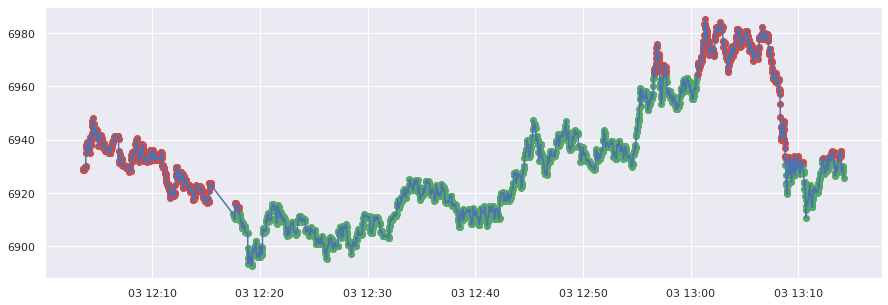

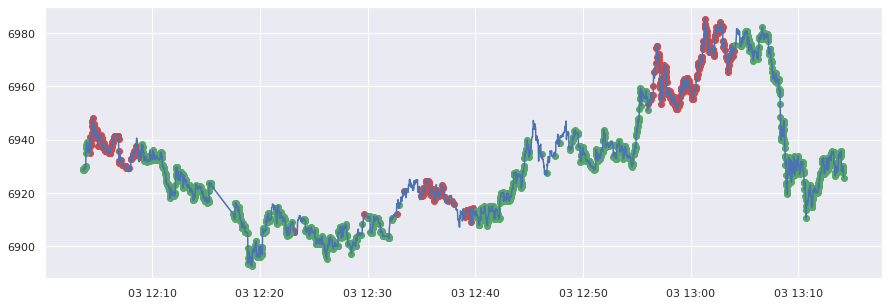

In [117]:
start = 62000
end = 65600
plot_predictions(X_test[start:end], y_not[start:end], target[X_test[start:end].index], probas, 0.75, 0.5)

In [42]:
from sklearn.metrics import precision_score

In [25]:
def custom(y_true, probas, number=200):
    best_p = 0
    best_prob = ()
    for p_down in np.arange(0.5, 1., 0.05):
        for p_up in np.arange(0.5, 1., 0.05):
            up = y_true[:,1]
            down = y_true[:,0]
            
            pred_up = probas['goes_up'] > p_up
            pred_down = probas['goes_down'] > p_down
            
            num = pred_up.sum() + pred_down.sum()
            if min(pred_up.sum() / (y_true.shape[0] / 3600.), pred_down.sum() / 
                   (y_true.shape[0] / 3600.)) < number:
                continue
            min_p = min(precision_score(up, pred_up), precision_score(down, pred_down))
            if min_p > best_p:
                best_p = min_p
                best_prob = (p_down, p_up)
    print(f'Probabilities: {best_prob}\nPrecision: {best_p}')

In [113]:
custom(y_test, probas)

Probabilities: (0.7500000000000002, 0.5)
Precision: 0.5696157663405643


# Альтернатива: предсказывать повышение/понижение цены спустя время #

In [179]:
se = target.asof(target.index + pd.Timedelta('1min'))
se.index = target.index
y_alt = (se > target).apply(int)

In [180]:
y_alt = y_alt[X.index]

In [181]:
y_alt_cat = tf.keras.utils.to_categorical(y_alt)

In [182]:
X_train, X_test, y_train, y_test = train_test_split(X, y_alt_cat, shuffle=False)

In [183]:
X_train, y_train = shuffle(X_train, y_train)

In [184]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), shuffle=False, epochs=2)

Train on 377366 samples, validate on 125789 samples
Epoch 1/2
377366/377366 [==============================] - 20s 52us/sample - loss: 0.6527 - accuracy: 0.6157 - val_loss: 0.7286 - val_accuracy: 0.5041
Epoch 2/2
377366/377366 [==============================] - 20s 53us/sample - loss: 0.6274 - accuracy: 0.6440 - val_loss: 0.7158 - val_accuracy: 0.5105


In [185]:
proba = model.predict(X_test)
probas = pd.DataFrame(proba, columns=['goes_down', 'goes_up'], index=X_test.index)
y_pred = (probas['goes_up'] > probas['goes_down']).apply(int)
y_pred.value_counts()

0    67135
1    58654
dtype: int64

In [186]:
y_not = y_test[:,1]

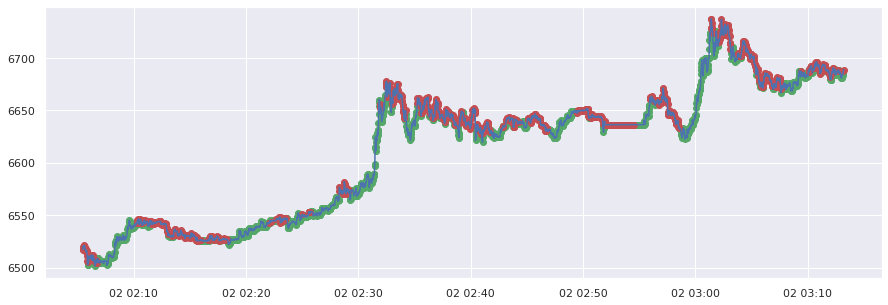

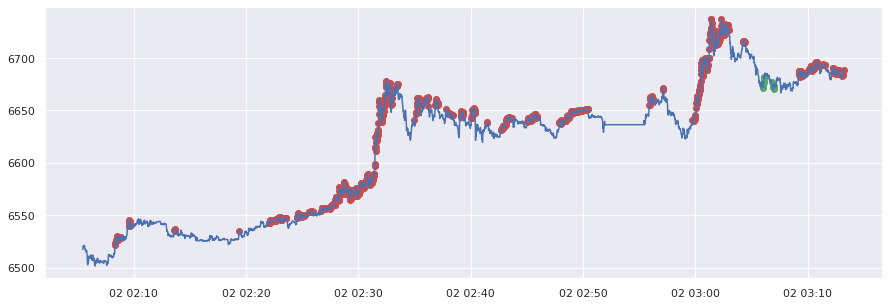

In [206]:
start = 10000
end = 13600
plot_predictions(X_test[start:end], y_not[start:end], target[X_test[start:end].index], probas, 0.75, 0.6)

# Не #

# Как насчет LSTM?#

In [11]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import warnings
from sklearn.model_selection import train_test_split
from stonks.auxiliary.model_selection import plot_predictions
warnings.filterwarnings('ignore')

In [12]:
data = week_data.copy()
X, y, scaler = make_x_y(data, mod=0.001)
y_cat = tf.keras.utils.to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_cat, shuffle=False)
y_not = y_test[:,1]
# X_train, y_train = shuffle(X_train, y_train)

In [117]:
train_gen = TimeseriesGenerator(X_train.values, y_train, 300, batch_size=64, shuffle=True,
                               sampling_rate=10)
val_gen = TimeseriesGenerator(X_test.values, y_test, 300, sampling_rate=10, batch_size=64)

In [127]:
model = tf.keras.Sequential(name='btcusdt model')
model.add(tf.keras.layers.LSTM(128, input_shape=(None, 109)))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(2, activation='softmax'))

model.compile('adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "btcusdt model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
unified_lstm_3 (UnifiedLSTM) (None, 128)               121856    
_________________________________________________________________
dropout_20 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_40 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_21 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_41 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_22 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_42 (Dense)             (None, 16)              

In [128]:
model.fit_generator(train_gen, epochs=1)

5889/5889 [==============================] - 150s 25ms/step - loss: 0.6087 - accuracy: 0.6377


In [129]:
proba = model.predict_generator(val_gen)
probas = pd.DataFrame(proba, columns=['goes_down', 'goes_up'], index=X_test[300:].index)
y_pred = (probas['goes_up'] > probas['goes_down']).apply(int)
y_pred.value_counts()

0    95628
1    29799
dtype: int64

In [130]:
from sklearn.metrics import accuracy_score, roc_auc_score
y_not = y_test[:,1]
print(accuracy_score(y_not[300:], y_pred), roc_auc_score(y_not[300:], y_pred))
custom(y_test[300:], probas, 100)

0.5025154073684295 0.5189819386642824
Probabilities: (0.8000000000000003, 0.5)
Precision: 0.5220406360424028


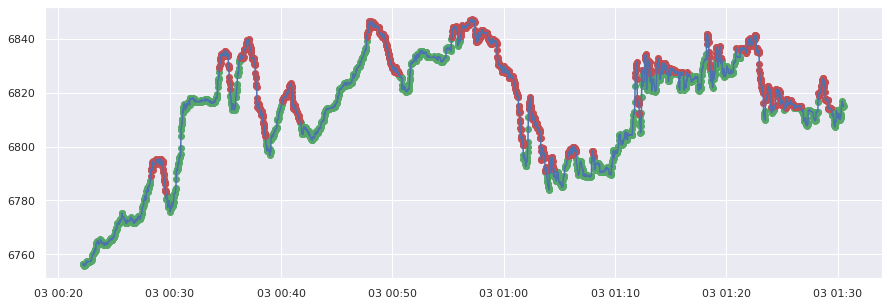

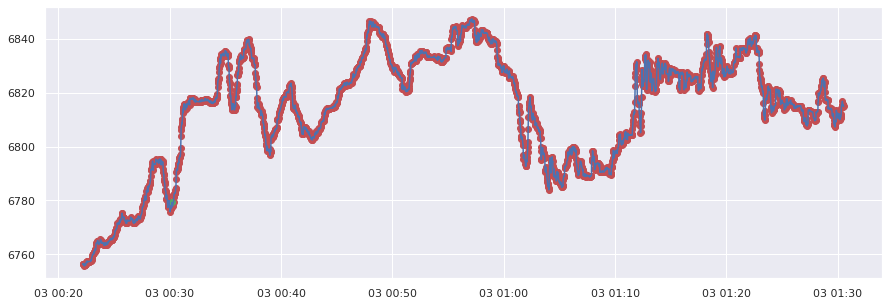

In [132]:
start = 20000
end = 23600
plot_predictions(X_test[start:end], y_not[start:end], target[X_test[start:end].index], probas, 0.5, 0.5)

# Наверное, все-таки не LSTM #

# Уходим в колаб #

# Не уходим #

# Возвращаясь к нашим баранам #

In [23]:
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score

In [13]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)

In [14]:
model = tf.keras.Sequential(name='btcusdt model')
model.add(tf.keras.layers.Dense(128, input_shape=(109,)))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(2, activation='softmax'))

model.compile('adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "btcusdt model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               14080     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 66        
Total params: 18,274
Trainable params: 18,274
Non-trainable params: 0
_________________________________________________________________


In [18]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=1)

Train on 291825 samples, validate on 97275 samples
291825/291825 [==============================] - 15s 51us/sample - loss: 0.6817 - accuracy: 0.5715 - val_loss: 0.7133 - val_accuracy: 0.5348


In [19]:
proba = model.predict(X_test)
probas = pd.DataFrame(proba, columns=['goes_down', 'goes_up'], index=X_test.index)
y_pred = (probas['goes_up'] > probas['goes_down']).apply(int)
y_pred.value_counts()

1    65431
0    31844
dtype: int64

In [26]:
print(accuracy_score(y_not, y_pred), roc_auc_score(y_not, y_pred))
custom(y_test, probas, 100)

0.53479311231046 0.5227435872648737
Probabilities: (0.5, 0.5)
Precision: 0.49934053510865467


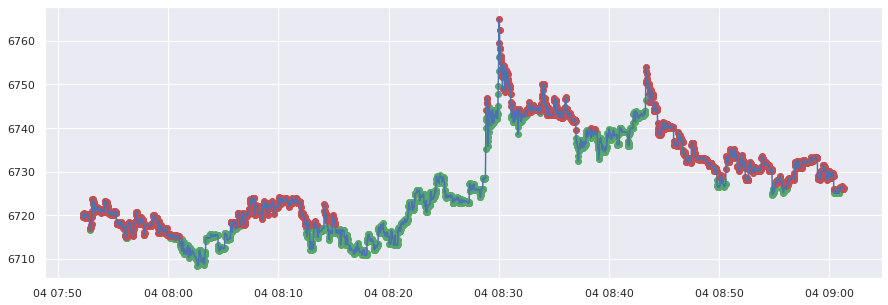

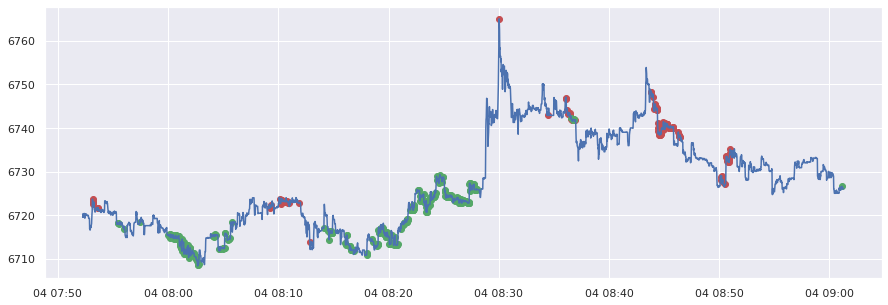

In [132]:
start = 50000
end = 53600
plot_predictions(X_test[start:end], y_not[start:end], target[X_test[start:end].index], probas, 0.7, 0.7)

In [139]:
target[X_test[start:end].index].argmax()

1969

In [146]:
target[X_test[start:end].index].index[1969]

Timestamp('2020-04-04 08:30:02.096358')

In [123]:
pup = 0.7
pdown = 0.7
y_pred = pd.Series(np.NaN, probas.index[start:end])
y_pred[probas[start:end]['goes_up'] > pup] = 1
y_pred[probas[start:end]['goes_down'] > pdown] = 0
y_pred.dropna(inplace=True)
y_pred.value_counts()

1.0    446
0.0    142
dtype: int64

In [46]:
y_true = pd.Series(y_not, index=y_pred.index)

In [65]:
y_true = y_true.apply(int)

In [129]:
red, green, val = stupid_metric(target[y_pred.index], y_pred, com=0.999)
val

0.9965802691069716

In [103]:
def stupid_metric(target, state, start=100, com=0.999):
    quote = start
    base = 0
    last = 0
    ind_red = []
    ind_green = []
    for ind in state.index:
        if state[ind] == 0:
            quote += target[ind] * base * com
            if base != 0:
                ind_red.append(ind)
            base = 0
            last = target[ind]
        else:
            base += quote / target[ind] * com
            if quote != 0:
                ind_green.append(ind)
            quote = 0
            last = target[ind]
    return ind_red, ind_green, (quote + base * last) / start

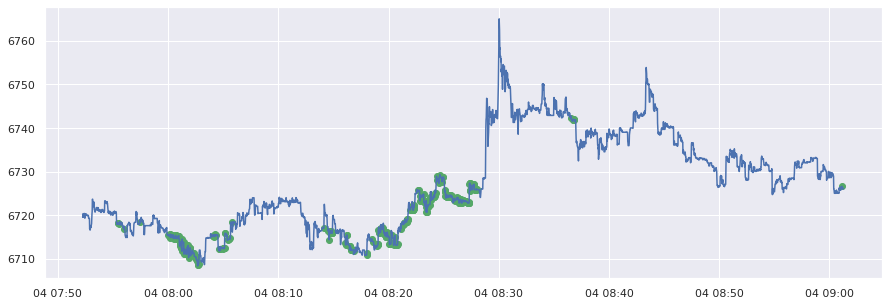

In [126]:
plt.figure(figsize=(15, 5))
plt.plot(target[y_true.index][start:end].index, target[y_true.index][start:end])
plt.scatter(y_pred[y_pred == 1].index, target[y_pred[y_pred == 1].index], color='g')
#plt.scatter(red, target[red], color='r', linewidth=3.)
#plt.scatter(green, target[green], color='g', linewidth=3.)